In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [11]:
with open("datasets/tinyShakespeare.txt", "r") as f:
    load = f.read()
print(load[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


# Longer sequences (20 chars)


In [14]:
texttoint = {elm: n for n, elm in enumerate(set(load))}
inttotext = {n:elm for n, elm in enumerate(set(load))}
dataset = [texttoint[c] for c in load]
vocab_size = len(texttoint)

sequence_length = 20

sequences = torch.tensor([dataset[i:-sequence_length+i-1] for i in range(sequence_length+1)]).T
inputs = sequences[:, :-1][2000:]
labels = sequences[:, -1][2000:]
val_inputs = sequences[:, :-1][:2000]
val_labels = sequences[:, -1][:2000]


We are getting a way better loss, around 1.9 instead of 2.5 <br> 
Now let's try a wider input sequence, 20 should allow us to cover 3-5 words

c:\Users\lucam\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch ___0 - Loss: 4.516
Epoch _200 - Loss: 3.033
Epoch _400 - Loss: 2.487
Epoch _600 - Loss: 2.475
Epoch _800 - Loss: 2.312
Epoch 1000 - Loss: 2.307
Epoch 1200 - Loss: 2.198
Epoch 1400 - Loss: 2.309
Epoch 1600 - Loss: 2.092
Epoch 1800 - Loss: 2.109


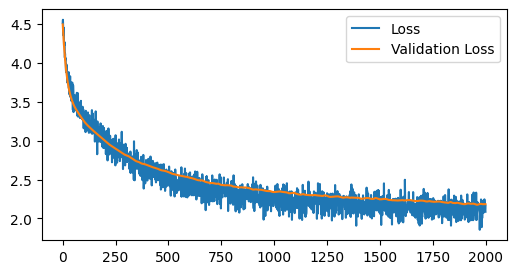

In [15]:
hidden_size = 128

w1 = torch.randn(vocab_size*sequence_length, hidden_size) * (6**0.5 / (vocab_size + hidden_size)**0.5)  
b1 = torch.zeros(hidden_size) 
w2 = torch.randn(hidden_size, vocab_size) * (6**0.5 / (vocab_size + hidden_size)**0.5)
b2 = torch.zeros(vocab_size)

params = [w1, b1, w2, b2]
for p in params:
    p.requires_grad_()

epochs = 2000
batch_size = 256
optimizer = torch.optim.Adam(params, lr=1e-3)
lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    X = F.one_hot(inputs[indexes].long(), vocab_size).float() # this has shape (batch_size, sequence_length, vocab_size), but we want (batch_size, vocab_size*sequence_length)
    X = X.reshape(batch_size, -1) # -1 means "infer the size from the other dimensions"
    h1 = F.gelu(X @ w1 + b1)
    pred = h1 @ w2 + b2
    loss = F.cross_entropy(pred, labels[indexes])

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        X = F.one_hot(val_inputs.long(), vocab_size).float().view(len(val_inputs), -1)
        h1 = F.gelu(X @ w1 + b1)
        pred = h1 @ w2 + b2
        vloss = F.cross_entropy(pred, val_labels)
        vlossi.append(vloss.item())

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

Running this model took way too much (around 3 times longer than before), and it seems harder to optimize let's explore why... 

In [16]:
for param, name in zip([w1, b1, w2, b2], ["w1", "b1", "w2", "b2"]):
    # print variable name, shape and number of parameters
    print(name, param.shape, param.numel())   

w1 torch.Size([1300, 128]) 166400
b1 torch.Size([128]) 128
w2 torch.Size([128, 65]) 8320
b2 torch.Size([65]) 65


The first layer has WAAAY too many parameters, it scales with sequence_length * vocab_size * hidden_size <br>
How can we improve on this? <br>
- Lowering sequence_length decreases performance
- vocab_size seems oddly inefficient with one_hot embeddings [0, 0, 0, 0, 1, 0, 0, 0]
- Lowering hidden_size decreases performance 

Let's think about vocab_size, right now with one_hot embeddings we are using 65 parameters to store a small int <br> 
We can't pass the int by itself, because neural networks are not good at picking up small differences in int values like that. <br><br>
One idea would be to reduce the dimensionality to something more managable, like 5 parameters, but how? <br>
We could simply make a list initialized at random of 5 parameter embeddigs for each value in the vocabulary... We call these embeddings <br>

Embeddings not only allow us to be more parameter efficient than one_hot encoding, they have O(n) complexity and allow us to map each integer value in the input space to a trained vector space where each embedding trends towards a good representation for the meaning of the inputs. 

# Embeddings

Epoch ___0 - Loss: 4.273
Epoch _200 - Loss: 2.884
Epoch _400 - Loss: 2.586
Epoch _600 - Loss: 2.573
Epoch _800 - Loss: 2.341
Epoch 1000 - Loss: 2.119
Epoch 1200 - Loss: 2.182
Epoch 1400 - Loss: 2.283
Epoch 1600 - Loss: 2.334
Epoch 1800 - Loss: 2.296


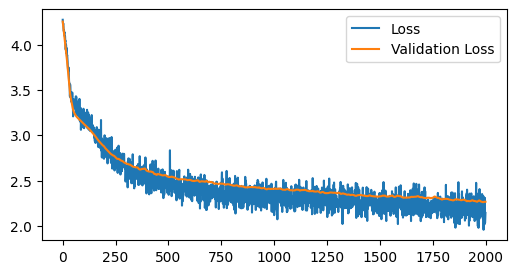

In [17]:
emb_size = 16  # I chose 16 parameter embeddings, but you can try different values
hidden_size = 128

embeddings = torch.randn(vocab_size, emb_size) / 10  # Assigning a random vector to each character in the vocabulary (this will be trained)
w1 = torch.randn(sequence_length*emb_size, hidden_size) * (6**0.5 / (vocab_size + hidden_size)**0.5)  
b1 = torch.zeros(hidden_size) 
w2 = torch.randn(hidden_size, vocab_size) * (6**0.5 / (vocab_size + hidden_size)**0.5)
b2 = torch.zeros(vocab_size)

params = [embeddings, w1, b1, w2, b2]
for p in params:
    p.requires_grad_()

epochs = 2000
batch_size = 256
optimizer = torch.optim.Adam(params, lr=1e-3)  # dont forget to add embeddings to the optimizer
lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    emb = embeddings[inputs[indexes]].view(batch_size, -1)
    h1 = F.gelu(emb @ w1 + b1)
    pred = h1 @ w2 + b2
    loss = F.cross_entropy(pred, labels[indexes])

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        emb = embeddings[val_inputs].reshape(len(val_inputs), -1)
        h1 = F.gelu(emb @ w1 + b1)
        pred = h1 @ w2 + b2
        vloss = F.cross_entropy(pred, val_labels)
        vlossi.append(vloss.item())

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

# Moving to pytorch nn.Module for cleaner code and better initialization
As you can see the model runs well, but now the complexity of the code is getting problematic, luckily pytorch has most of this already implemented. 
Just like we did before with the loss and the optimizer, here we can substitute the layers with pre made ones. 

In [18]:
class MLP(nn.Module):
    def __init__(self, emb_size, hidden_size):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.w1 = nn.Linear(emb_size*sequence_length, hidden_size)
        self.w2 = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        h1 = F.gelu(self.w1(emb))
        return self.w2(h1)
    
model = MLP(emb_size=10, hidden_size=128)

Epoch ___0 - Loss: 4.190
Epoch _200 - Loss: 2.823
Epoch _400 - Loss: 2.528
Epoch _600 - Loss: 2.404
Epoch _800 - Loss: 2.240
Epoch 1000 - Loss: 2.333
Epoch 1200 - Loss: 2.243
Epoch 1400 - Loss: 2.150
Epoch 1600 - Loss: 2.144
Epoch 1800 - Loss: 2.202


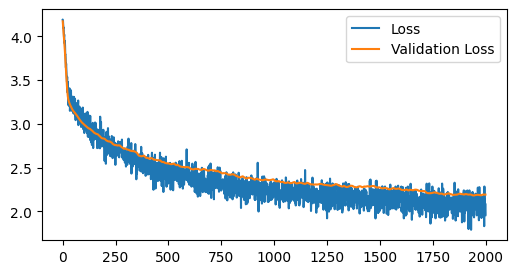

In [19]:
epochs = 2000
batch_size = 256
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes]) # everything in the forward pass happens in the model class
    loss = F.cross_entropy(pred, labels[indexes])

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        pred = model(val_inputs)
        vloss = F.cross_entropy(pred, val_labels)
        vlossi.append(vloss.item())

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

# GPUs for extremely fast parallel execution

As you can see the torch version works just as well, if not better and it's all around more refined

Using nn.Module class from pytorch also allows us to execute the code on the GPU, which is way faster


In [20]:
device = torch.device("cuda:0")  # Set the device to GPU (cuda) 
model = MLP(emb_size=10, hidden_size=128).to(device)  # Send the model to GPU

AssertionError: Torch not compiled with CUDA enabled

Epoch ___0 - Loss: 4.217
Epoch 1000 - Loss: 2.155
Epoch 2000 - Loss: 1.984
Epoch 3000 - Loss: 1.940
Epoch 4000 - Loss: 1.806
Epoch 5000 - Loss: 1.846
Epoch 6000 - Loss: 1.907
Epoch 7000 - Loss: 1.876
Epoch 8000 - Loss: 2.063
Epoch 9000 - Loss: 1.996


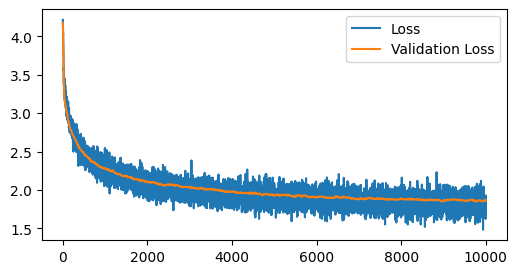

In [7]:
epochs = 10000
batch_size = 256
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device))  # Send the inputs to GPU
    loss = F.cross_entropy(pred, labels[indexes].to(device))  # Send the labels to GPU

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

The performance of the model is the same but everything happens in about a third of the time on my pc (ryzen 3100 and 3060 12GB) <br>
Note: GPUs are often bandwith bound, not compute bound, so higher batch sizes play well with text, for example it may be that from 1 to 512 the training time stays basically the same, because the gpu is able to compute all of these in parallel and under a certain batch size you will not be taking advantage of this. <br>
Now let's train it for a while and take a look at some predictions

In [9]:
string = "             \nKING RICHARD I"
print(string, end="")

with torch.no_grad():
    for _ in range(1000):
        X = torch.tensor([texttoint[s] for s in string[-sequence_length:]]).long().view(1, -1).to(device)
        pred = model.forward(X)
        string += inttotext[torch.multinomial(F.softmax(pred, dim=1), 1).item()]
        print(string[-1], end="")


             
KING RICHARD III:
Hall be.

LEONNENE:
Ye looke swack tivison
Ares? Yow helpomed loor to to ay in all so che wannow on stry by whit sighined's cord lubligh-- eatly.

Sdiest to grown cut liks: all camed spord you
A telerd fhere she out sir suvisaly, and leings is hath,
Dord thed I can thee tooth lamshour have greven's O;
En such it the rows shatitiles mincresele sorvyest I
hourpunct:
Meo, that shall and filler of all so,
kive dives answeak in meng thes aigh--ndch,
That keather if rease proush And bany Fidentrene cole Korasurs.
Shall thee with hish wits the manast is alt
And, and if roings my noie.

CLUMIO:
O not ro no seear how sie plevor be his say, and to the whicheow serthe himsich who bear nose
onter:
A ver
tousedf,ich! I werattlling, the nosterne, Comes of may dhis sich-some the to gratliait,
FJ by thes putis of the rother; he'd sor sirs to see hear swech
Than to ry suretrined, wreat;
Tife more's, ban of on he
Beirn I stan wisther me wore-bros, one finsighs ding didine

The model is spitting out nosense but it clearly resembles the text it's trained on... Let's see how we can improve on this in part 5